In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
import pandas
from sklearn.utils import class_weight
from sklearn import metrics as me

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from labelsUtils import (
    Label,
)

from regionUtils import (
    vietnam_labels_coordinates,
)

from rasterUtils import (
    make_dataset_from_raster_files,
)

from convNetUtils import (
    cross_validation,
    plot_confusion_matrix,
)

In [2]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    PANCHROMATIC = 7
    CIRRUS = 8
    TIRS1 = 9
    TIRS2 = 10

In [3]:
NB_PIXEL_AROUND = 4
TRAIN_TEST_RATIO = 0.8
EPOCHS = 100
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()
BANDS = [
    Band.BLUE.value,
    Band.RED.value,
    Band.NIR.value
]

In [4]:
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

labels_names = [label.name for label in labels]

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_march/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [6]:
mean_loss, mean_accuracy, histories = cross_validation(dataset, BANDS, labels, labels_names, EPOCHS)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 9, 9, 3)]         0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 9, 9, 3)           0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 8)           224       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 8)           584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 16)          528       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 16)          1040

Epoch 45/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1015 - accuracy: 0.5432 - val_loss: 1.2250 - val_accuracy: 0.4691
Epoch 46/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1559 - accuracy: 0.4793 - val_loss: 1.2011 - val_accuracy: 0.4900
Epoch 47/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1191 - accuracy: 0.4943 - val_loss: 1.0779 - val_accuracy: 0.5736
Epoch 48/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1009 - accuracy: 0.5434 - val_loss: 1.1562 - val_accuracy: 0.4969
Epoch 49/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0951 - accuracy: 0.4988 - val_loss: 1.1214 - val_accuracy: 0.5437
Epoch 50/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1191 - accuracy: 0.5251 - val_loss: 1.1161 - val_accuracy: 0.5316
Epoch 51/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0183 - accuracy: 0.5206 - val_loss: 1.1243 - val_accuracy: 0.5448
Epoch 

57/57 [==============================] - 0s 8ms/step - loss: 1.7957 - accuracy: 0.1979 - val_loss: 1.7859 - val_accuracy: 0.2175
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 1.7731 - accuracy: 0.2276 - val_loss: 1.5786 - val_accuracy: 0.2724
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 1.4084 - accuracy: 0.3236 - val_loss: 1.3022 - val_accuracy: 0.4471
Epoch 5/100
57/57 [==============================] - 0s 8ms/step - loss: 1.2382 - accuracy: 0.3758 - val_loss: 1.3128 - val_accuracy: 0.3380
Epoch 6/100
57/57 [==============================] - 0s 8ms/step - loss: 1.2609 - accuracy: 0.3923 - val_loss: 1.2936 - val_accuracy: 0.3926
Epoch 7/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1469 - accuracy: 0.3897 - val_loss: 1.2599 - val_accuracy: 0.3736
Epoch 8/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1668 - accuracy: 0.3562 - val_loss: 1.2470 - val_accuracy: 0.4471
Epoch 9/100
57/57 [======

Epoch 60/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9271 - accuracy: 0.5442 - val_loss: 1.1808 - val_accuracy: 0.5029
Epoch 61/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9913 - accuracy: 0.4987 - val_loss: 1.1022 - val_accuracy: 0.5485
Epoch 62/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9761 - accuracy: 0.5546 - val_loss: 1.1539 - val_accuracy: 0.5180
Epoch 63/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1020 - accuracy: 0.4891 - val_loss: 1.1205 - val_accuracy: 0.5306
Epoch 64/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9705 - accuracy: 0.5432 - val_loss: 1.1032 - val_accuracy: 0.5474
Epoch 65/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9955 - accuracy: 0.5394 - val_loss: 1.1474 - val_accuracy: 0.5139
Epoch 66/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0281 - accuracy: 0.5265 - val_loss: 1.0668 - val_accuracy: 0.5630
Epoch 

57/57 [==============================] - 0s 8ms/step - loss: 1.2308 - accuracy: 0.3950 - val_loss: 1.3067 - val_accuracy: 0.3733
Epoch 18/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1148 - accuracy: 0.4565 - val_loss: 1.2305 - val_accuracy: 0.3846
Epoch 19/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1357 - accuracy: 0.3797 - val_loss: 1.2338 - val_accuracy: 0.4030
Epoch 20/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1594 - accuracy: 0.3956 - val_loss: 1.1671 - val_accuracy: 0.4211
Epoch 21/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1610 - accuracy: 0.4296 - val_loss: 1.1960 - val_accuracy: 0.4110
Epoch 22/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1839 - accuracy: 0.3866 - val_loss: 1.1718 - val_accuracy: 0.4589
Epoch 23/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1636 - accuracy: 0.4305 - val_loss: 1.1357 - val_accuracy: 0.4896
Epoch 24/100
57/57 

Epoch 75/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9544 - accuracy: 0.5127 - val_loss: 1.1288 - val_accuracy: 0.5115
Epoch 76/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9623 - accuracy: 0.5232 - val_loss: 1.1087 - val_accuracy: 0.5075
Epoch 77/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9778 - accuracy: 0.5132 - val_loss: 1.1001 - val_accuracy: 0.5420
Epoch 78/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0256 - accuracy: 0.5261 - val_loss: 1.1187 - val_accuracy: 0.5101
Epoch 79/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0794 - accuracy: 0.4619 - val_loss: 1.1132 - val_accuracy: 0.5172
Epoch 80/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9579 - accuracy: 0.5225 - val_loss: 1.1290 - val_accuracy: 0.5307
Epoch 81/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9290 - accuracy: 0.5188 - val_loss: 1.0448 - val_accuracy: 0.5583
Epoch 

57/57 [==============================] - 0s 8ms/step - loss: 1.1316 - accuracy: 0.4693 - val_loss: 1.1997 - val_accuracy: 0.4265
Epoch 33/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1497 - accuracy: 0.4262 - val_loss: 1.1654 - val_accuracy: 0.4739
Epoch 34/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1069 - accuracy: 0.4310 - val_loss: 1.3009 - val_accuracy: 0.3979
Epoch 35/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0667 - accuracy: 0.4487 - val_loss: 1.1718 - val_accuracy: 0.4824
Epoch 36/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1108 - accuracy: 0.4318 - val_loss: 1.2499 - val_accuracy: 0.4230
Epoch 37/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0810 - accuracy: 0.4507 - val_loss: 1.2540 - val_accuracy: 0.3979
Epoch 38/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1368 - accuracy: 0.4341 - val_loss: 1.1982 - val_accuracy: 0.4170
Epoch 39/100
57/57 

Epoch 90/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9336 - accuracy: 0.5514 - val_loss: 1.1154 - val_accuracy: 0.5193
Epoch 91/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9243 - accuracy: 0.5542 - val_loss: 1.1274 - val_accuracy: 0.5245
Epoch 92/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9247 - accuracy: 0.5361 - val_loss: 1.1286 - val_accuracy: 0.5358
Epoch 93/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9172 - accuracy: 0.5362 - val_loss: 1.1100 - val_accuracy: 0.5488
Epoch 94/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9462 - accuracy: 0.5276 - val_loss: 1.1195 - val_accuracy: 0.5470
Epoch 95/100
57/57 [==============================] - 0s 8ms/step - loss: 0.8581 - accuracy: 0.5796 - val_loss: 1.2117 - val_accuracy: 0.5098
Epoch 96/100
57/57 [==============================] - 0s 8ms/step - loss: 0.8936 - accuracy: 0.5520 - val_loss: 1.1348 - val_accuracy: 0.5383
Epoch 

57/57 [==============================] - 0s 8ms/step - loss: 1.0347 - accuracy: 0.5029 - val_loss: 1.1249 - val_accuracy: 0.5292
Epoch 48/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0938 - accuracy: 0.5278 - val_loss: 1.0947 - val_accuracy: 0.5590
Epoch 49/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9956 - accuracy: 0.5331 - val_loss: 1.0957 - val_accuracy: 0.5652
Epoch 50/100
57/57 [==============================] - 0s 8ms/step - loss: 0.9774 - accuracy: 0.5298 - val_loss: 1.1292 - val_accuracy: 0.5431
Epoch 51/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0572 - accuracy: 0.5218 - val_loss: 1.1363 - val_accuracy: 0.4839
Epoch 52/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0135 - accuracy: 0.5406 - val_loss: 1.1454 - val_accuracy: 0.5337
Epoch 53/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0350 - accuracy: 0.5073 - val_loss: 1.1569 - val_accuracy: 0.4811
Epoch 54/100
57/57 

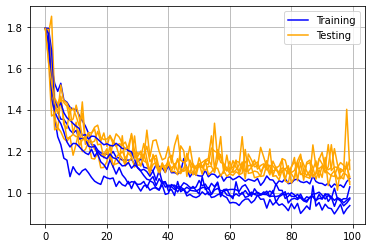

In [9]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

In [10]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  1.0866732835769652
mean accuracy:  0.5462770700454712


In [15]:
# classes = [label.name for label in [Label.COFFEE, Label.NATIVEVEGE, Label.URBAN, Label.WATER, Label.PEPPER, Label.TEA]]

# pred = model.predict_on_batch(X_test)
# pred = np.argmax(pred, axis=-1)

# confusion_matrix = me.confusion_matrix(y_test, pred)
# plot_confusion_matrix(confusion_matrix, classes)

In [ ]:
#  print(me.classification_report(y_test, pred, target_names=classes))